<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# We will use one implementation of Keras called tensorflow.keras.
# There are also other implementations of Keras
# See Ch.10 of [Ge19]
# from tensorflow import keras

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import plot_model


# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
!pip install git+git://github.com/stared/livelossplot.git
from livelossplot.keras import PlotLossesCallback


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat

Using TensorFlow backend.


  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-5ltquj7s
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-5ltquj7s
  Created wheel for livelossplot: filename=livelossplot-0.4.2-cp36-none-any.whl size=12661 sha256=034472d292c1c6372daee5593b701ca92400db959cb4a8ac1ce2ff32e8c4027d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7kngijr/wheels/77/01/ea/cef3581d9c77ece0fd685cc3eb1cd92dc68d8117b361ac65dc
Successfully built livelossplot
--2020-03-16 18:29:40--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3865 (3.8K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[

# Use case description

The use case is from [KhConf19].


**Goal** Estimate available bandwidth in a network via **passive measures**.

More precisely:
_Estimate the capacity available to a TCP flow_ (sharing links with other flows) observing
* The time gaps between segments sent $g_{\text{in}}$
* The gaps between acks $g_\text{ack}$



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/ack.png)
\[Figure from [KhThesis19] \]


The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.

# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y).

In [2]:
!wget https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip

--2020-03-16 18:29:42--  https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip
Resolving www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)... 130.75.2.72
Connecting to www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)|130.75.2.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 941822 (920K) [application/zip]
Saving to: ‘BandwidthEstimationTraces.zip’

BandwidthEstimation 100%[===================>] 919.75K   429KB/s    in 2.1s    

2020-03-16 18:29:45 (429 KB/s) - ‘BandwidthEstimationTraces.zip’ saved [941822/941822]



In [0]:
! unzip -o -q BandwidthEstimationTraces.zip

In [4]:
!ls BandwidthEstimationTraces

testing  training


Training and test datasets are separated

In [5]:
! ls BandwidthEstimationTraces/training

MultiLinkCapacity100   TightLinkafterBottleneckLink
SingleLinkCapacity100  TightLinkbeforeBottleneckLink
SingleLinkCapacity50


For simplicity, we will just consider the case with a single link between client and server, of total capacity C=100 Mbps (Ethernet level)

In [6]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100

25_et_100_C_5_delta  50_et_100_C_5_delta  75_et_100_C_5_delta


There are three sets of traces:
* With cross traffic rate $\lambda$=25 Mbps
* With cross traffic rate $\lambda$=50 Mbps
* With cross traffic rate $\lambda$=75 Mbps

All rates are intended at the Ethernet level

In [7]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta

75_et_100_C_5_delta_100.csv  75_et_100_C_5_delta_55.csv
75_et_100_C_5_delta_10.csv   75_et_100_C_5_delta_56.csv
75_et_100_C_5_delta_11.csv   75_et_100_C_5_delta_57.csv
75_et_100_C_5_delta_12.csv   75_et_100_C_5_delta_58.csv
75_et_100_C_5_delta_13.csv   75_et_100_C_5_delta_59.csv
75_et_100_C_5_delta_14.csv   75_et_100_C_5_delta_5.csv
75_et_100_C_5_delta_15.csv   75_et_100_C_5_delta_60.csv
75_et_100_C_5_delta_16.csv   75_et_100_C_5_delta_61.csv
75_et_100_C_5_delta_17.csv   75_et_100_C_5_delta_62.csv
75_et_100_C_5_delta_18.csv   75_et_100_C_5_delta_63.csv
75_et_100_C_5_delta_19.csv   75_et_100_C_5_delta_64.csv
75_et_100_C_5_delta_1.csv    75_et_100_C_5_delta_65.csv
75_et_100_C_5_delta_20.csv   75_et_100_C_5_delta_66.csv
75_et_100_C_5_delta_21.csv   75_et_100_C_5_delta_67.csv
75_et_100_C_5_delta_22.csv   75_et_100_C_5_delta_68.csv
75_et_100_C_5_delta_23.csv   75_et_100_C_5_delta_69.csv
75_et_100_C_5_delta_24.csv   75_et_100_C_5_delta_6.csv
75_et_100_C_5_delta_25.csv   75_et_100_C_5_delta_7

Every experiment is repeated 100 times.

Let's check the trace of one experiment

In [8]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df

,100,25
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280
5,1.10830,29.9820
6,1.27700,35.3180
7,1.27810,39.9750
8,1.24280,44.5390
9,1.42630,50.0520


The header is not a sample. It just tells us the scenario, i.e. total channel capacity (Mbps) and available bandwith (Mbps).

The columns are:
* $g_\text{in} / g_\text{ack}$
* Some sort of time stamp that we will ignore (not well described in the dataset)

Let's rename the columns to avoid ambiguity

In [9]:
df.columns=['gap_ratio', 'timestamp']
df.head()

,gap_ratio,timestamp
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280


# Feature engineering

Each experiment will be a sample.

The features of a sample are the elements of the histogram of the first column

(array([2.46797799, 1.23398899, 0.6169945 , 1.23398899, 1.23398899,
        1.23398899, 1.23398899, 0.6169945 , 0.6169945 , 1.85098349]),
 array([0.99982 , 1.080858, 1.161896, 1.242934, 1.323972, 1.40501 ,
        1.486048, 1.567086, 1.648124, 1.729162, 1.8102  ]),
 <a list of 10 Patch objects>)

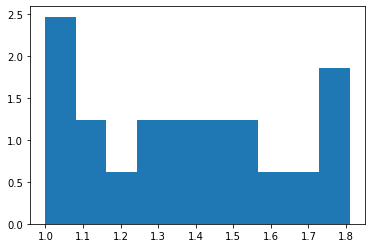

In [10]:
plt.hist(df['gap_ratio'], density=True)

# density:  True garantees that the area is 1 (such that hist approximates a 
#                 probability densitplt.hist(x)y function)

However, the sequence of bins is chosen automatically by `matplotlib` and may change from an experiment to another.

We need instead to describe all the experiments with a uniform set of features => The sequence of bins must be the same for all the experiments.

To do so:
* Take the min and max gap from all the experiments
* Divide the [min,max] interval uniformly

In [11]:
min_gap = float('inf')
max_gap = 0
for cross_traf in ['25', '50', '75']:
  for exp_id in range(1,101):
    filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/" +\
                cross_traf + "_et_100_C_5_delta/"+\
                cross_traf + "_et_100_C_5_delta_"+str(exp_id)+".csv"

    # print('Checking ',filename)
    df = pd.read_csv(filename)
    df.columns=['gap_ratio', 'timestamp']
    trace_min = min( df['gap_ratio'] )
    trace_max = max( df['gap_ratio'] )
    min_gap = min ( [ min_gap, trace_min ] )
    max_gap = max ( [ max_gap, trace_max ] )

print('min_gap:', min_gap, ' max_gap:',max_gap)


min_gap: 0.9737399999999999  max_gap: 2.0635


Let's create the bins that we will use for all experiments

In [12]:
N = 8 # num of bins

bin_size = (max_gap-min_gap)/N 
bins = [min_gap + i * bin_size for i in range(0, N+1)]
bins

[0.9737399999999999,
 1.10996,
 1.2461799999999998,
 1.3824,
 1.5186199999999999,
 1.65484,
 1.7910599999999999,
 1.92728,
 2.0635]

Just as a visual check, let's plot again the previous histogram with these new bins

[2.20231978 0.3670533  1.10115989 1.83526648 0.3670533  1.10115989
 0.3670533  0.        ]


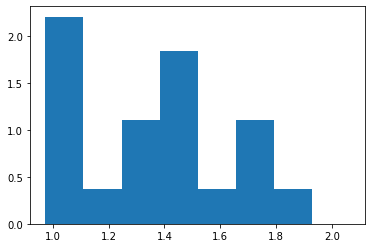

In [13]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df.columns=['gap_ratio', 'timestamp']
hist_values, bins, bars = plt.hist( df['gap_ratio'], density=True, bins=bins)
print(hist_values )

Let's obtain the histogram for all the experiments. For each experiment, we construct a feature vector:

  `[bin1_freq, bin2_freq, ...., binN_freq]`

and a label `avail_bandwidth`.

We write these operations in a function `construct_dataset` that we will then use for the training and the test dataset

In [0]:
def from_str_to_num(the_str):
  num = 0 
  if the_str=='25': num=0
  elif the_str=='50': num=1
  elif the_str=='75': num=2
  else: raise ValueError('Value ', the_str, ' is not valid')
  return num;


def construct_dataset(filepath, bins):

  X = np.empty((0,N), int)
  y = np.empty((0,1), int)

  for cross_traf in ['25', '50', '75']:
    for exp_id in range(1,101):
      filename = filepath +\
                  cross_traf + "_et_100_C_5_delta/"+\
                  cross_traf + "_et_100_C_5_delta_"+str(exp_id)+".csv"

      df = pd.read_csv(filename)

      # Observe that for each experiment, the available bandwidth corresponds to the
      # name of the second column
      avail_band = from_str_to_num( df.columns[1] )


      df.columns=['gap_ratio', 'timestamp']

      hist_values, bins, bars = plt.hist( df['gap_ratio'], density=True, bins=bins)

      X = np.vstack(( X, hist_values) )
      y = np.vstack(( y, avail_band) )

  y = y.reshape(-1,1)
  return X,y

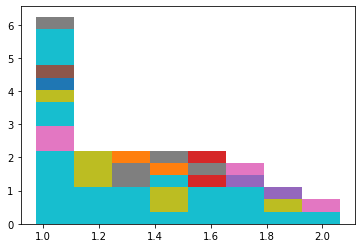

In [15]:
X_train, y_train = construct_dataset(
    "BandwidthEstimationTraces/training/SingleLinkCapacity100/", 
    bins)
X_test, y_test = construct_dataset(
    "BandwidthEstimationTraces/testing/SingleLinkCapacity100/",
    bins)

In [16]:
print('X_train\n', X_train[0:6, :] )
print('\n\ny_train\n',y_train )

X_train
 [[6.23990603 1.10115989 0.         0.         0.         0.
  0.         0.        ]
 [6.23990603 1.10115989 0.         0.         0.         0.
  0.         0.        ]
 [5.50579944 1.10115989 0.3670533  0.3670533  0.         0.
  0.         0.        ]
 [5.87285274 0.73410659 0.73410659 0.         0.         0.
  0.         0.        ]
 [5.50579944 1.10115989 0.73410659 0.         0.         0.
  0.         0.        ]
 [5.50579944 1.46821318 0.3670533  0.         0.         0.
  0.         0.        ]]


y_train
 [[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]

With NN is important to **scale** the dataset

In [17]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('X_train_scaled', X_train_scaled[0:6, :] )

X_train_scaled [[1.         0.5        0.         0.         0.         0.
  0.         0.        ]
 [1.         0.5        0.         0.         0.         0.
  0.         0.        ]
 [0.84615385 0.5        0.2        0.16666667 0.         0.
  0.         0.        ]
 [0.92307692 0.33333333 0.4        0.         0.         0.
  0.         0.        ]
 [0.84615385 0.5        0.4        0.         0.         0.
  0.         0.        ]
 [0.84615385 0.66666667 0.2        0.         0.         0.
  0.         0.        ]]


# Build a NN model

To train faster, change the runtime to GPU.

Now, let's build a NN architecture. The size of each sample is:

In [18]:
sample_size = X_train_scaled.shape[1]
print('The sample size is ', sample_size, 
      ', which should correspond to the number of bins ', N)

The sample size is  8 , which should correspond to the number of bins  8





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 15        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


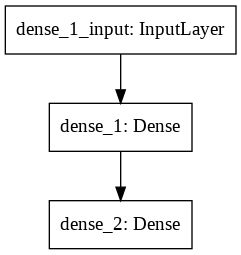

In [19]:
num_of_classes = 3

model = Sequential([
  Dense(4, input_dim=sample_size, activation='relu' ),
  Dense(num_of_classes, activation="softmax")
])

# The first layer has 4 neurons and take 8 input values.
# In the first layer, you always need to specify the input_dim
#
# Note that each layer adds implicitly a bias term (we do not need to care about 
# it)
#
# The last layer is a softmax, since we are doing classification


model.summary()
plot_model(model)

`None` means that the batch size can be any value.

Compile the model, i.e., decide the loss function to minimize, the optimization function and the metrics to show

In [20]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(lr=0.01) ,
              metrics=['accuracy'])

From Ch.10 of [Ge19]:

Loss function:
* Use `sparse_categorical_cross entropy` when there is just one target value (as in our case). 
* If target were one-hot encoded, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], then use `categorical_crossentropy` instead. 
* In binary classification then use `sigmoid` activation function in the output layer instead of the `softmax` and `binary_crossentropy` loss.

Optimizer:
* We are using Stochastic Gradient Descent with learning rate $\eta=0.01$

Metrics:
* We are asking Keras to show at each epoch the accuracy. Note that the accuracy value is ignored during training. This metric is just visualized

# Training

To train faster, change the runtime to GPU.

In [0]:
plot_losses = PlotLossesCallback()

wannatrain = False
if wannatrain:
  history = model.fit(X_train_scaled, y_train, epochs=1000, 
                    callbacks = [plot_losses] )

To avoid spending time for training, I add directly the results

![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/bad_training.png)

Our NN is a disaster! Let's anyway check the performance on the test set

In [22]:
y_pred = model.predict(X_test_scaled)
y_pred[0:5,:]

array([[0.3902147 , 0.267775  , 0.34201026],
       [0.42000073, 0.26834854, 0.31165075],
       [0.42000073, 0.26834854, 0.31165075],
       [0.39733875, 0.26717833, 0.33548284],
       [0.42167723, 0.2688818 , 0.30944103]], dtype=float32)

In [0]:

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np




y_proba
 [[0.3902147  0.267775   0.34201026]
 [0.42000073 0.26834854 0.31165075]
 [0.42000073 0.26834854 0.31165075]
 [0.39733875 0.26717833 0.33548284]
 [0.42167723 0.2688818  0.30944103]]
y_pred
 [0 0 0 0 0]
labels_present [0 1 2]
Normalized confusion matrix
[[1.   0.   0.  ]
 [1.   0.   0.  ]
 [0.95 0.   0.05]]


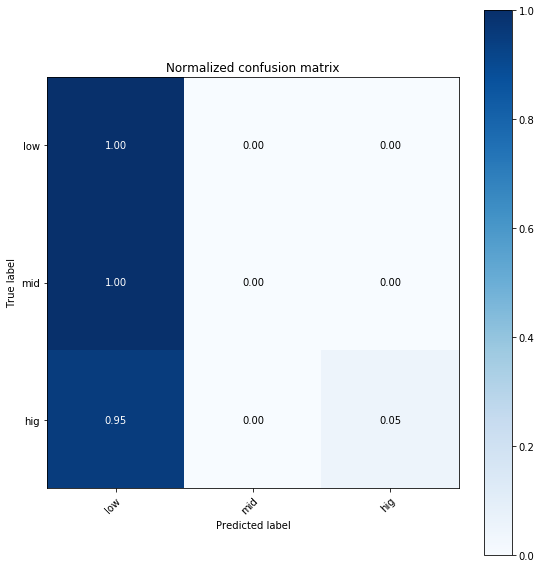

In [51]:
y_proba = model.predict(X_test_scaled)
print( 'y_proba\n', y_proba[0:5] )

y_pred = model.predict_classes(X_test_scaled)
print( 'y_pred\n', y_pred[0:5] )

class_names = np.array( ['low', 'mid', 'hig'] )
plot_conf_mat(y_test, y_pred, class_names, normalize=True)


# Limitation of the work

* Only a finite set of available bandwidth values are used (25, 50, 75 Mbps). In reality, any value can occur => Need to extend the test and validation test with random bandwidth values.

# References

* [Ge19] Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2019, O'Reilly
* [KhConf19] Khangura, S. K. (2019). Neural Network-based Available Bandwidth Estimation from TCP Sender-side Measurements. In IEEE/IFIP PEMWN.
* [KhThesis19] Khangura, S. K. (2019). Machine Learning-based Available Bandwidth Estimation. Leibniz University.